## 1. Import libraries

In [1]:
import pickle
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve,root
from scipy.optimize import minimize
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('classic')

## 2. Constitutive model

The second example concerns elasto-plastic porous media (for more, see Riley et al., 2023). The reference constitutive model is built on three state variables: elastic strain ($\varepsilon^e$), bulk density ($\rho$), and solid fraction $\phi=\rho/\rho_s$, where $\rho_s$ is the solid density, defined as the ratio of the mass of the solid phase over its volume. The same model can additionally be extended to brittle materials by accounting for the dependence on the granular temperature, although this is neglected in the present work (by selecting $c=0$, Eq. 19 in Riley et al., 2023).

Following this model, the specific internal energy is defined as

\begin{equation}
\widehat{u}(\rho,\bm{\varepsilon^e}) = \left( \dfrac{\rho}{\rho_s^*}\right) \left( \dfrac{1}{2}K{\varepsilon_v^e}^2+\dfrac{3}{2}G{\varepsilon^e_s}^2\right),
\label{eq:energy_DR}
\end{equation}

where $\rho_s^*$ is the unstressed solid density, which is a material parameter. Despite the aforementioned internal energy function does not depend on the solid fraction, the latter is responsible for density hardening of the bounding surface. The evaluation is based on the following model parameters: bulk modulus $K=10$ MPa and shear modulus $G=6$ MPa, the slope of the critical state line $M=1.5$, the dimensionless parameter that determines the effective isotropic yield pressure $\beta^*=0.1$, and the unstressed solid density $\rho_s^*=600$ kg/m$^3$.

For more, we refer to:

D Riley, I Einav, and F Guillard. A constitutive model for porous media with recurring stress drops:
From snow to foams and cereals. *International Journal of Solids and Structures*, 262:112044, 2023. doi:
10.1016/j.ijsolstr.2022.112044.

### 2.1 Define constitutive and evolution equations

In [2]:
def elastic_energy(ee, r):
    return (r/r_st)*(K/2*ee[0]**2+3/2*G*ee[1]**2)

def Stress(ee, r):
    p = (r/r_st)*K*ee[0]
    q = (r/r_st)*3*G*ee[1]
    return p,q

def find_strain(ee, r, sigma):
    p,q = Stress(ee, r)
    return np.hstack((p-sigma[0],q-sigma[1]))

def py(phi):
    return beta*K*((1-phi)**(-3)-1)

def ya(xi,pe,qe,phi):
    return (2*pe/(xi*py(phi))-1)**2+(2*qe/(xi*M*py(phi)))**2-1

def dyadpe(xi,pe,qe,phi):
    return 8*pe/(xi**2*py(phi)**2)-4/(xi*py(phi))

def dyadqe(xi,pe,qe,phi):
    return 8*qe/(xi**2*M**2*py(phi)**2)

def dpedeev(r,ee):
    return r/r_st*K

def dqedees(r,ee):
    return r/r_st*3*G

def macaulay(x):
    return np.where(x<0,0,x)

def dpedrho(r,ee):
    return K*ee[0]/r_st

def dqedrho(r,ee):
    return 3*G*ee[1]/r_st

def dyadpy(xi,pe,qe,phi):
    return -8*pe**2/(xi**2*py(phi)**3)+4*pe/(xi*py(phi)**2)-8*qe**2/(xi**2*M**2*py(phi)**3)

def dpydphi(phi):
    return 3*beta*K/(1-phi)**4


def dya(lmbda,xi,pe,qe,phi,ee,r,dot_ev,dot_es):
    l = macaulay(lmbda)
    
    x = xi
    dot_eev = dot_ev-l*dyadpe(x,pe,qe,phi)
    dot_ees = dot_es-l*dyadqe(x,pe,qe,phi)
    dot_phi = phi*l*dyadpe(x,pe,qe,phi)
    dot_rho = r*dot_ev
    
    
    dot_ya = dyadpe(x,pe,qe,phi)*dpedeev(r,ee)*dot_eev
    dot_ya += dyadqe(x,pe,qe,phi)*dqedees(r,ee)*dot_ees
    dot_ya += (dyadpe(x,pe,qe,phi)*dpedrho(r,ee)
               +dyadqe(x,pe,qe,phi)*dqedrho(r,ee)
              )*dot_rho
    dot_ya += dyadpy(x,pe,qe,phi)*dpydphi(phi)*dot_phi
    return (dot_ya-ya(x,pe,qe,phi))

def find_LA(xi,pe,qe,phi,ee,r,dot_ev,dot_es):
    LA = (dyadpe(xi,pe,qe,phi)*dpedeev(r,ee)*dot_ev
          +dyadqe(xi,pe,qe,phi)*dqedees(r,ee)*dot_es
          +(dyadpe(xi,pe,qe,phi)*dpedrho(r,ee) + dyadqe(xi,pe,qe,phi)*dqedrho(r,ee))*r*dot_ev
         )
    LA /= (dyadpe(xi,pe,qe,phi)*dpedeev(r,ee)*dyadpe(xi,pe,qe,phi)
           +dyadqe(xi,pe,qe,phi)*dqedees(r,ee)*dyadqe(xi,pe,qe,phi)
           -dyadpy(xi,pe,qe,phi)*dpydphi(phi)*phi*dyadpe(xi,pe,qe,phi)
          )
    return LA

### 2.2 Define initial value problem for strain- and stress-driven loading path

In [3]:
tol=1e-24

def evol_state(t,statet,dot_e,x,lmbd):
    ''' Strain-controlled loading path '''
    phi = statet[0]
    r = statet[1]
    ee = statet[2:4]
    ep = statet[4:6]
    ss = statet[6:8]
    pe,qe = ss[0],ss[1]
    dot_ev,dot_es = dot_e[0],dot_e[1]

    xi = (M**2 * pe**2 + qe**2) / (M**2 * pe * py(phi)+tol)
    x[:] = xi
    lmbda = find_LA(xi,pe,qe,phi,ee,r,dot_ev,dot_es)
    lmbda = macaulay(lmbda)
    
    dot_epv = xi*lmbda*dyadpe(xi,pe,qe,phi)
    dot_eps = xi*lmbda*dyadqe(xi,pe,qe,phi)
    dot_eev = dot_ev-dot_epv
    dot_ees = dot_es-dot_eps
    dot_phi = phi*dot_epv
    dot_rho = r*dot_ev

    dot_p = dpedeev(r,ee)*dot_eev+dpedrho(r,ee)*dot_rho
    dot_q = dqedees(r,ee)*dot_ees+dqedrho(r,ee)*dot_rho

    return np.hstack((dot_phi,dot_rho,
                      dot_eev,dot_ees,
                      dot_epv,dot_eps,
                      dot_p,dot_q,
                      dot_e))
    
def evol_stress(t,statet,dot_e,x,lmbd):
    ''' Stress-controlled loading path '''
    phi = statet[0]
    r = statet[1]
    ee = statet[2:4]
    ep = statet[4:6]
    ss = statet[6:8]
    pe,qe = ss[0],ss[1]
        
    dot_ev,dot_es = dot_e[0],dot_e[1]
    
    
    dot_e3 = root(stress_increment, args=(dot_e[0],statet,x,lmbd),x0=[dot_e[0]/10000],tol=1e-12).x
    dot_ev = dot_e[0]+2*dot_e3
    dot_es = (np.sqrt(2/3)*(dot_e[0]-dot_e3))
    dot_e = np.hstack((dot_ev,dot_es))
    
    
    xi = (M**2 * pe**2 + qe**2) / (M**2 * pe * py(phi))
    x[:] = xi
    lmbda = find_LA(xi,pe,qe,phi,ee,r,dot_ev,dot_es)
    lmbda = macaulay(lmbda)
    lmbd[:] = lmbda
    
    dot_epv = xi*lmbda*dyadpe(xi,pe,qe,phi)
    dot_eps = xi*lmbda*dyadqe(xi,pe,qe,phi)
    dot_eev = dot_ev-dot_epv
    dot_ees = dot_es-dot_eps
    dot_phi = phi*dot_epv
    dot_rho = r*dot_ev

    dot_p = dpedeev(r,ee)*dot_eev+dpedrho(r,ee)*dot_rho
    dot_q = dqedees(r,ee)*dot_ees+dqedrho(r,ee)*dot_rho

    return np.hstack((dot_phi,dot_rho,
                      dot_eev,dot_ees,
                      dot_epv,dot_eps,
                      dot_p,dot_q,
                      dot_e))


def stress_increment(dot_e3,dot_e1_target,statet,x,lmbd):
    ''' Find strain-increments to satisfy stress-controlled loading path '''
    phi = statet[0]
    r = statet[1]
    ee = statet[2:4]
    ep = statet[4:6]
    ss = statet[6:8]
    pe,qe = ss[0],ss[1]

    dot_ev = dot_e1_target+2*dot_e3
    dot_es = np.sqrt(2/3)*(dot_e1_target-dot_e3)
    
    xi = (M**2 * pe**2 + qe**2) / (M**2 * pe * py(phi))  
    lmbda = find_LA(xi,pe,qe,phi,ee,r,dot_ev,dot_es)
    lmbda = macaulay(lmbda)
    dot_epv = xi*lmbda*dyadpe(xi,pe,qe,phi)
    dot_eps = xi*lmbda*dyadqe(xi,pe,qe,phi)
    dot_eev = dot_ev-dot_epv
    dot_ees = dot_es-dot_eps
    dot_phi = phi*dot_epv
    dot_rho = r*dot_ev

    dot_p = dpedeev(r,ee)*dot_eev+dpedrho(r,ee)*dot_rho
    dot_q = dqedees(r,ee)*dot_ees+dqedrho(r,ee)*dot_rho

    return (dot_p+0*dot_q/3)

### 2.3 Solution of the initial value problem

In [4]:
def solve(state_t,deps,dt,x,lmbd):
    ''' Strain-controlled IVP '''
    eps_dot = deps/dt
    sol = solve_ivp(evol_state,
                args=[eps_dot[:2],x,lmbd],
                    t_span=[0.,dt],
                    t_eval=[dt],
                    y0=state_t,
                    vectorized=False,
                    atol = 1.e-15,
                    rtol = 1.e-14,
                    method='LSODA')
    if sol.success==True:
        sol = sol.y[:,-1]
    else: print('cannot converge')
    return sol


def solve_drained(state_t,deps,dt,x,lmbd):
    ''' Stress-controlled IVP '''
    eps_dot = deps/dt
    sol = solve_ivp(evol_stress,
                args=[eps_dot[:2],x,lmbd],
                    t_span=[0.,dt],
                    t_eval=[dt],
                    y0=state_t,
                    vectorized=False,
                    atol = 1e-14,
                    rtol =  1e-13,
                    method='DOP853')
    if sol.success==True:
        sol = sol.y[:,-1]
    else: print('cannot converge')
    return sol

### 2.4 Material parameters

In [5]:
eta = 1.
K = 10.
nu = 0.25
G = 3*K*(1-2*nu)/(2+2*nu)
beta = 0.02
M = 1.5
r_st = 600.e-6

## 3. Loading paths

Data are generated by applying single loading-unloading strain-loading paths, with constant strain rate, as for the previous benchmark. In order to characterise the influence of the solid fraction, four specimens are considered with $\phi^{\mathrm{init}} = {0.5,0.6,0.7,0.8}$ at the initial unstressed configuration. This is done to mimic a hypothetical experimental acquisition where the state variables of only a finite and reduced number of configurations can be actually investigated.

From the unstressed configuration, we apply isotropic compression to generate states at different confining pressures, $p\in [1000, 8500]$ kPa, which are followed by numerical experiments composed of undrained and drained triaxial compression and isotropic extension.

### 3.1 Isotropic compression - generation of samples

In [6]:
N = 4
n_reset = 200 # number of increments before resetting
increments = N*n_reset # number of increments

mod= 1e-2
id_de=0
subincrements = n_reset
sub = increments//subincrements
deps_inc_sub = np.zeros((sub,3))
deps_inc_sub[:,id_de]= mod*np.random.choice(np.array([1,1]),sub)
delta = np.zeros((increments,3))
for i in np.arange(0,increments//subincrements,1):
    k = i*subincrements
    for j in range(subincrements):
        delta[k+j] = deps_inc_sub[i]

dt=1.
state_t = np.zeros((increments+1,10))
state_rst = np.zeros((N,10))

phi_ini = 0.5
phi0 = phi_ini
p_ini = 1.e-12
p0 = p_ini
dphi = 0.1
q_0 = 0.0

emax = 1.
emin = 0.1
Dr0 = 0.1
e_0 = emax-Dr0*(emax-emin)
n0 = e_0 / (1. + e_0)
phi0 = 1. - n0
phi0 = 0.5




sub = subincrements-40
for i in range(increments):

    if not i % n_reset:
        if i!=0:
            phi0 += 0.1
        r_0 = phi0*r_st
        if p0/py(phi0)>=1.:
            print('ERROR, yielding at initial point!',p0/py(phi0))
            p0 = py(phi0)*0.99
        e_0 = fsolve(find_strain, args=(r_0,np.hstack((p0,q_0))),x0=np.zeros((2)))
        state_t0 = np.hstack((phi0,r_0,e_0,np.zeros((2)),np.hstack((p0,q_0)),e_0))
        state_t = state_t0.copy()
        state_rst[i//n_reset] = state_t0.copy()
        x=np.array([0.0])
        lmbd = np.array([1.e-6])
        k+=1

    state_t_ = solve(state_t,delta[i],dt,x,lmbd)
    if state_t_[7]<0.:
        delta[i:i+subincrements-i%subincrements]=0*np.abs(delta[i:i+subincrements-i%subincrements])
        state_t_ =solve(state_t,delta[i],dt,x,lmbd)
    if state_t_[-4]<=0.0:
        delta[i:i+subincrements-i%subincrements]=np.abs(delta[i:i+subincrements-i%subincrements])
        state_t_ =solve(state_t,delta[i],dt,x,lmbd)
    state_t = state_t_.copy()
    if i == 0:
        state_t_hist = np.array([state_t.copy()])
    else:
        state_t_hist = np.append(state_t_hist, np.array([state_t]), axis=0) 

/home/fil/anaconda3/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


### 3.1 Undrained triaxial compression-extension

In [7]:
N = 6
n_reset = 140 # number of increments before resetting
increments = N*n_reset # number of increments

mod= 2e-2
id_de = 1
subincrements = n_reset//2
sub = increments//subincrements
deps_inc_sub = np.zeros((sub,3))
deps_inc_sub[:,id_de]= mod*np.random.choice(np.array([1,-1]),sub)
delta = np.zeros((increments,3))
for i in np.arange(0,increments//subincrements,1):
    k = i*subincrements
    for j in range(subincrements):
        delta[k+j] = deps_inc_sub[i]

dt=1.
state_t = np.zeros((increments+1,10))
state_rst = np.zeros((N,10))

p_ini = 1.0
p0 = p_ini
dphi = 0.1
q_0 = 0.0

# Initial value of the solid fraction
phi0 = 0.5+2*0.1

sub = subincrements//2

n=1.5

for i in range(increments):

    if not i % n_reset:
        delta[i:i+sub]=np.abs(delta[i:i+sub])
        delta[i+sub:]=-np.abs(delta[i+sub:])
        
        if i!=0:
            p0+=n
        file = '../CModel/reference_data/RE_isotropic_05_08'
        with open(file, 'rb') as f_obj:
            data = pickle.load(f_obj)
        [svars_t,batch_time] = data
        svars_t = np.reshape(svars_t,(batch_time,-1,svars_t.shape[-1]),order='F')

        Dr_arr = np.arange(0.5,0.8,0.1)
        idr = (phi0-0.5)/0.1
        idr = round(idr)
        svars_t = svars_t[:,idr]
        id_ = np.where(svars_t[:,-4]>p0)
        if len(id_[0])>0:
            id_ = id_[0][0]
            state_t0 = svars_t[id_]
        else:
            print('Confining pressure too high')
            state_t0 = svars_t[-1]
        state_t = state_t0.copy()
        state_rst[i//n_reset] = state_t0.copy()
        x=np.array([0.0])
        lmbd = np.array([1.e-6])
        k+=1

    state_t_ = solve(state_t,delta[i],dt,x,lmbd)
    if x[0]>1+1e-3:
        print(x[0])
    if state_t_[7]<0.:
        delta[i:i+subincrements-i%subincrements]=0*np.abs(delta[i:i+subincrements-i%subincrements])
        state_t_ =solve(state_t,delta[i],dt,x,lmbd)
    if state_t_[-4]>=py(state_t_[0]):
        py(state_t_[0])
    if state_t_[-4]<=0.0:
        delta[i:i+subincrements-i%subincrements]=0*np.abs(delta[i:i+subincrements-i%subincrements])
        state_t_ =solve(state_t,delta[i],dt,x,lmbd)
    state_t = state_t_.copy()
    if i == 0:
        state_t_hist = np.array([state_t.copy()])
    else:
        state_t_hist = np.append(state_t_hist, np.array([state_t]), axis=0) 

### 3.2 Drained triaxial loading-unloading

In [8]:
N = 6
n_reset = 140 # number of increments before resetting
increments = N*n_reset # number of increments

mod= 2e-2
id_de=0
subincrements = n_reset//1
sub = increments//subincrements
deps_inc_sub = np.zeros((sub,3))
deps_inc_sub[:,id_de]= mod*np.random.choice(np.array([1,-1]),sub)
delta = np.zeros((increments,3))
for i in np.arange(0,increments//subincrements,1):
    k = i*subincrements
    for j in range(subincrements):
        delta[k+j] = deps_inc_sub[i]

dt=1.
state_t = np.zeros((increments+1,10))
state_rst = np.zeros((N,10))


p_ini = 1.0
p0 = p_ini
dphi = 0.1
q_0 = 0.0

# Initial value of the solid fraction
phi0 = 0.5+2*0.1

sub = subincrements-70

n=1.5

for i in range(increments):

    if not i % n_reset:
        delta[i:i+sub]=np.abs(delta[i:i+sub])
        delta[i+sub:]=-np.abs(delta[i+sub:])
        if i!=0:
            p0+=n
        file = '../CModel/reference_data/RE_isotropic_05_08'
        with open(file, 'rb') as f_obj:
            data = pickle.load(f_obj)
        [svars_t,batch_time] = data
        svars_t = np.reshape(svars_t,(batch_time,-1,svars_t.shape[-1]),order='F')

        Dr_arr = np.arange(0.5,0.8,0.1)
        idr = (phi0-0.5)/0.1
        idr = round(idr)
        svars_t = svars_t[:,idr]
        id_ = np.where(svars_t[:,-4]>p0)
        if len(id_[0])>0:
            id_ = id_[0][0]
            state_t0 = svars_t[id_]
        else:
            print('Confining pressure too high')
            state_t0 = svars_t[-1]
            
        state_t = state_t0.copy()
        state_rst[i//n_reset] = state_t0.copy()
        x=np.array([0.0])
        lmbd = np.array([1.e-6])
        k+=1
    state_t_ = solve_drained(state_t,delta[i],dt,x,lmbd)
    if state_t_[7]<0.:
        delta[i:i+subincrements-i%subincrements]=np.abs(delta[i:i+subincrements-i%subincrements])
        state_t_ =solve_drained(state_t,delta[i],dt,x,lmbd)
    if state_t_[-4]<=0.0:
        delta[i:i+subincrements-i%subincrements]=0*np.abs(delta[i:i+subincrements-i%subincrements])
        state_t_ =solve_drained(state_t,delta[i],dt,x,lmbd)
    state_t = state_t_.copy()
    if i == 0:
        state_t_hist = np.array([state_t.copy()])
    else:
        state_t_hist = np.append(state_t_hist, np.array([state_t]), axis=0) 

### 3.3 Isotropic compression-extension

In [9]:
N = 4#8*4#*6#5*4#7*2#8*4
n_reset = 140 # number of increments before resetting
increments = N*n_reset # number of increments

mod= 2e-2
id_de = 0
subincrements = n_reset#//4
sub = increments//subincrements
deps_inc_sub = np.zeros((sub,3))
deps_inc_sub[:,id_de]= mod*np.random.choice(np.array([1,1]),sub)
delta = np.zeros((increments,3))
for i in np.arange(0,increments//subincrements,1):
    k = i*subincrements
    if not i%2:
        deps_inc_sub[i]=np.abs(deps_inc_sub[i])
    else:
        deps_inc_sub[i] = -np.abs(deps_inc_sub[i])
    for j in range(subincrements):
        delta[k+j] = deps_inc_sub[i]

dt=1.
state_t = np.zeros((increments+1,10))
state_rst = np.zeros((N,10))

p_ini = 1.e-12
p0 = p_ini
dphi = 0.1
q_0 = 0.0


# Initial value of the solid fraction
phi0 = 0.5

sub = subincrements-100

n=1.5

for i in range(increments):

    if not i % n_reset:
        delta[i:i+sub]=np.abs(delta[i:i+sub])
        delta[i+sub:]=-np.abs(delta[i+sub:])
        
        if i!=0:
            phi0 += dphi
        file = '../CModel/reference_data/RE_isotropic_05_08'
        with open(file, 'rb') as f_obj:
            data = pickle.load(f_obj)
        [svars_t,batch_time] = data
        svars_t = np.reshape(svars_t,(batch_time,-1,svars_t.shape[-1]),order='F')

        Dr_arr = np.arange(0.5,0.8,0.1)
        idr = (phi0-0.5)/0.1
        idr = round(idr)
        svars_t = svars_t[:,idr]
        id_ = np.where(svars_t[:,-4]>p0)
        if len(id_[0])>0:
            id_ = 0
            state_t0 = svars_t[id_]
        else:
            print('Confining pressure too high')
            state_t0 = 0
        state_t = state_t0.copy()
        state_rst[i//n_reset] = state_t0.copy()
        x=np.array([0.0])
        lmbd = np.array([1.e-6])
        k+=1
    state_t_ = solve(state_t,delta[i],dt,x,lmbd)
    if state_t_[7]<0.:
        delta[i:i+subincrements-i%subincrements]=0*np.abs(delta[i:i+subincrements-i%subincrements])
        state_t_ =solve(state_t,delta[i],dt,x,lmbd)
    if state_t_[-4]<=0.0:
        delta[i:i+subincrements-i%subincrements]=0*np.abs(delta[i:i+subincrements-i%subincrements])
        state_t_ =solve(state_t,delta[i],dt,x,lmbd)
    state_t = state_t_.copy()
    if i == 0:
        state_t_hist = np.array([state_t.copy()])
    else:
        state_t_hist = np.append(state_t_hist, np.array([state_t]), axis=0) 

## 4. Define and store state evolution

In [10]:
svars_t=np.array([state_t_hist[i-1] for i in range(0,increments)])
for i in np.arange(0,len(svars_t),n_reset):
    svars_t[i]= state_rst[i//n_reset]

In [11]:
phi = svars_t[:,0]
rho = svars_t[:,1]
ee = svars_t[:,2:4]
epl = svars_t[:,4:6]
stress = svars_t[:,6:8]
strain = svars_t[:,8:10]

In [12]:
svars_tdt = state_t_hist.copy()
phi_tdt = svars_tdt[:,0]
rho_tdt = svars_tdt[:,1]
ee_tdt = svars_tdt[:,2:4]
epl_tdt = svars_tdt[:,4:6]
stress_tdt = svars_tdt[:,6:8]
strain_tdt = svars_tdt[:,8:10]

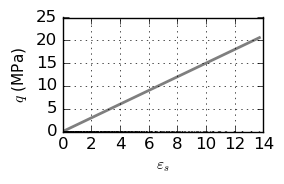

In [13]:
fig = plt.figure(dpi=100, figsize=(3,2), tight_layout=True)

ax = fig.subplots(1)
ax.plot(np.linspace(0,np.amax(stress[:,0]),100),M*np.linspace(0,np.amax(stress[:,0]),100),'o',color='black',
        alpha=0.5,markersize=0,linewidth=2,linestyle='-',)
ax.plot(stress[:,0],stress[:,1],'o',color='black',alpha=1,markersize=1,linewidth=0,linestyle='-',)
ax.set_ylabel('$q$ (MPa)',fontsize="11")
ax.set_xlabel('$\\varepsilon_s$',fontsize="11")
ax.grid()
fig.patch.set_facecolor('white')

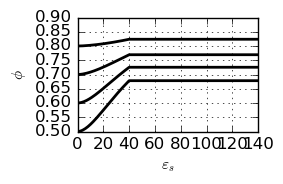

In [14]:
fig = plt.figure(dpi=100, figsize=(3,2.), tight_layout=True)
ax = fig.subplots(1)
for i in range(increments//n_reset):
    ax.plot(phi[n_reset*i:n_reset*(1+i)],'o',color='black',alpha=1,markersize=0,linewidth=2,linestyle='-',)
ax.set_ylabel('$\\phi$',fontsize="11")
ax.set_xlabel('$\\varepsilon_s$',fontsize="11")
ax.grid()
ax.set_ylim(0.5,0.9)
fig.patch.set_facecolor('white')

In [15]:
# If sample generation:
# data = [svars_t,n_reset]
# with open('./RE_isotropic_05_08', 'wb') as f_obj:
#     pickle.dump(data, f_obj)

In [16]:
# Else:
data = [stress,strain,ee,epl,rho,phi,stress_tdt,strain_tdt,ee_tdt,epl_tdt,rho_tdt,phi_tdt,dt,n_reset]
with open('./MAT2_loading_path', 'wb') as f_obj:
     pickle.dump(data, f_obj)